In [1]:
using BenchmarkTools

In [2]:
struct Graph
    chains
    nodes
end

In [3]:
chains = [["074559265", "033293546", "177194634", "132327031",
        "05942608X", "147936594", "194946746", "20308523X",
        "160289750", "103659625", "103664262", "07456501X", "074559192",
        "074576127", "113270321", "123899249", "122925262", "121644545",
        "122935314", "13235103X", "149658192", "149531125", "151099103", "168078465", "17817310X", "18105938X", "181232529", "195092317", "202363856"], ["069862753", "033922020", "185417396", "185923089", "161170161", "188021574", "188160396", "188705945", "189504048", "189565624", "189997680", "190237201", "06986263X", "074589644", "076964361", "076694348", "076969576", "083593217", "110189159", "129545279"], ["112512380", "109209265", "185124100", "180818260", "185775926", "185887015", "187849390", "18786425X", "188021574", "112508901"], ["129545678", "129545279", "140093052", "154959588", "155289756", "176736999", "177538619", "179791338", "177523824", "195092317"],
        ["177539135", "177538619", "200874586", "241318939"]];

In [4]:
# Define the graph
nodes_list = unique(n for ch in chains for n in ch)
nodes = Dict( n=>k for (k, n) in enumerate(nodes_list) )
println(length(nodes), " nodes")
println("#chains: ", length(chains))
graph = Graph(chains, nodes);

69 nodes
#chains: 5


In [5]:
# Search for intersections
intersections = Dict()
for (ch_idx, ch) in enumerate(graph.chains), n in ch
    el = get!(intersections, n, Int64[])
    push!(el, ch_idx)
    end;

filter!(x -> length(x[2]) > 1, intersections);
println(length(intersections), " intersections")
print(intersections)

4 intersections
Dict{Any,Any}("177538619" => [4, 5],"195092317" => [1, 4],"188021574" => [2, 3],"129545279" => [2, 4])

In [7]:
# Place the first chain
function place_first_chain!(coords, graph, chain_idx=1) 
    chain = graph.chains[chain_idx]
    node_distance = 1.0f0

    chain_idx = map(x -> graph.nodes[x], chain);

    line = hcat([ [node_distance*(i-1); 0] for i in 1:length(chain)]...)
    coords[:, chain_idx] = line
    end;

In [97]:
function place_chain!(coords, graph, chain_idx)
# coords, graph, chain_idx

    # Check if the coordinates are not notching
    # i.e. if the node has been placed
    iscoordsdefined(n) = any(x->~isnothing(x), coords[:, graph.nodes[n]])

    #function get_knots(
    #coords, graph,   )
    chain = graph.chains[chain_idx]
    knots = [(idx_along_chain, coords[:, graph.nodes[n]])
                    for (idx_along_chain, n) in enumerate(chain)
                    if iscoordsdefined(n)]

    if length(knots)==0
        println("zero intersection")
        end;
    # si un seul noeud...
    # choisir une direction perpendiculoïde
    # si une seule chaine rencontrée
    # find nodes avant et après de cette chaine rencontrée
    if length(knots)==1
        idx_along_chain = knots[1][1]
        n = chain[idx_along_chain]

        other_chains = filter(i -> i != chain_idx, intersections[n])
        other_chain_id = other_chains[1]  # take the first anyway (TODO: multiple crossing...)

        other_chain = graph.chains[other_chain_id]
        idx_along_other_chain = findfirst(isequal(n), other_chain)

        coords_other_chain(idx) = coords[:, graph.nodes[other_chain[ idx ]]]

        println("intersection with chain #", other_chain_id,
            " at node #", idx_along_other_chain)

        # Define a normal direction
        if idx_along_other_chain == 1
            before = coords[:, graph.nodes[other_chain[1]]]
            next = coords[:, graph.nodes[other_chain[2]]]
        elseif idx_along_other_chain == length(other_chain)
            before = coords[:, graph.nodes[other_chain[end-1]]]
            next = coords[:, graph.nodes[other_chain[end]]]
        else
            before = coords[:, graph.nodes[other_chain[idx_along_other_chain-1]]]
            next = coords[:, graph.nodes[other_chain[idx_along_other_chain]]]
            end;

        # normal direction:
        u = next .- before
        norm = sqrt(u[1]^2 + u[2]^2)
        direction = [u[2]/norm; -u[1]/norm]

        # ajoute un noeud
        # si ce n'est pas le dernier alors le suivant
        # sinon le precedent
        # TODO: make a random choice, left or right?
        coords_n = knots[1][2]
        if idx_along_chain < length(chain)
            push!(knots, (idx_along_chain+1, coords_n .+ direction))
        else
            push!(knots, (idx_along_chain-1, coords_n .- direction))
            end;

        end;

    println("knots: ", knots)
    # Lagrange interpolation
    el(j, x) = prod(m -> if (j != m); (x - knots[m][1])/(knots[j][1] - knots[m][1]) else 1 end, 1:length(knots))
    L(x) = sum(j -> knots[j][2].*el(j, x), 1:length(knots))

    x = range(1, length(chain), step=1)


    idx_chain = map(x -> graph.nodes[x], chain); # not the same as chain_idx unfortunatly
    coords[:, idx_chain] = hcat(L.(x)...)
    end;

In [143]:
# get intersecting chains
function get_intersected(chain_id)
    chain = graph.chains[chain_id]
    intersected = Set{Int64}()
    for n in chain
        union!(intersected, get(intersections, n, []))
        end;
    setdiff!(intersected, chain_id)
    return sort(collect(intersected), by=x->length(graph.chains[x]))
    end;

In [158]:
# Init empty coords array
coords = Array{Union{Nothing, Float32}}(nothing, 2, length(graph.nodes))

place_first_chain!(coords, graph)
added_chain = [1, ]
chains_to_add = get_intersected(1);

In [163]:
next_chain = pop!(chains_to_add)
println("add chain #", next_chain, "  ", chains_to_add)
place_chain!(coords, graph, next_chain)
push!(added_chain, next_chain)
println("added_chain", added_chain)

append!(chains_to_add, filter(x -> ~(x in added_chain),
        get_intersected(next_chain)))
println("chains_to_add  ", chains_to_add)

add chain #5  Int64[]
intersection with chain #4 at node #7
knots: Tuple{Int64,Array{Union{Nothing, Float32},1}}[(2, [27.0f0, 3.0f0]), (3, [26.0f0, 3.0f0])]
added_chain[1, 4, 2, 3, 5]
chains_to_addInt64[]


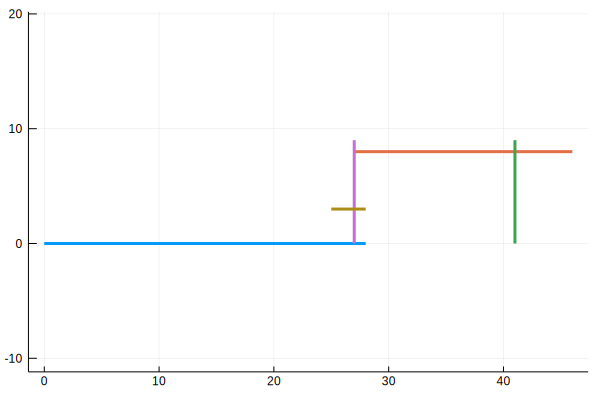

In [164]:
fig = plot(legend=false, aspect_ratio=:equal)
#scatter!(coords[:, 1], coords[:, 2], linewidth=2)
for chain in graph.chains
    chain_idx = map(x -> graph.nodes[x], chain);
    x = coords[1, chain_idx]
    y = coords[2, chain_idx]
    if ~any(isnothing, x)
        plot!(x, y, linewidth=3)
        end;
    #println(coords[idx, 1])
    end;
fig

In [82]:
using(Plots)